In [1]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings, Flatten
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, BatchNormalization
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras import models
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import time
from keras import models, optimizers

Using TensorFlow backend.


In [2]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

In [3]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [4]:
WEIGHTS_PATH_NO_TOP = "squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [5]:
def SqueezeNet(include_top=False, weights='imagenet',
               input_tensor=None, input_shape=(224,224,3),
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            pass
        
            
        model.load_weights(WEIGHTS_PATH_NO_TOP)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [6]:
sqnet = SqueezeNet(include_top=False,weights='imagenet')

In [7]:
sqnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

In [8]:
x = sqnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = Dense(128,activation='relu')(x)
x = Dense(6,activation='softmax')(x)
first_model = Model(inputs=sqnet.input, outputs=x)

In [9]:
first_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

In [10]:
for i,layer in enumerate(first_model.layers):
    print(i,layer.name,layer.trainable)

0 input_1 False
1 conv1 True
2 relu_conv1 True
3 pool1 True
4 fire2/squeeze1x1 True
5 fire2/relu_squeeze1x1 True
6 fire2/expand1x1 True
7 fire2/expand3x3 True
8 fire2/relu_expand1x1 True
9 fire2/relu_expand3x3 True
10 fire2/concat True
11 fire3/squeeze1x1 True
12 fire3/relu_squeeze1x1 True
13 fire3/expand1x1 True
14 fire3/expand3x3 True
15 fire3/relu_expand1x1 True
16 fire3/relu_expand3x3 True
17 fire3/concat True
18 pool3 True
19 fire4/squeeze1x1 True
20 fire4/relu_squeeze1x1 True
21 fire4/expand1x1 True
22 fire4/expand3x3 True
23 fire4/relu_expand1x1 True
24 fire4/relu_expand3x3 True
25 fire4/concat True
26 fire5/squeeze1x1 True
27 fire5/relu_squeeze1x1 True
28 fire5/expand1x1 True
29 fire5/expand3x3 True
30 fire5/relu_expand1x1 True
31 fire5/relu_expand3x3 True
32 fire5/concat True
33 pool5 True
34 fire6/squeeze1x1 True
35 fire6/relu_squeeze1x1 True
36 fire6/expand1x1 True
37 fire6/expand3x3 True
38 fire6/relu_expand1x1 True
39 fire6/relu_expand3x3 True
40 fire6/concat True
41 fire7

In [11]:
for layer in first_model.layers[:41]:
    layer.trainable= False

In [12]:
train_data_set = './Training'
validation_set = './Validation'
test_data_set = './Test'

In [13]:
train_data_gen = ImageDataGenerator(rescale=1.0/255,rotation_range=15, shear_range=0.2,width_shift_range=0.13,height_shift_range=0.13,zoom_range=[0.6,0.2],horizontal_flip=True,fill_mode='nearest',data_format='channels_last')
valid_data_gen = ImageDataGenerator(rescale=1.0/255,data_format='channels_last')
train_set = train_data_gen.flow_from_directory(train_data_set,target_size=(224,224),batch_size=16,class_mode='categorical',shuffle=True,color_mode='rgb')
valid_set = valid_data_gen.flow_from_directory(validation_set,target_size=(224,224),batch_size=16,class_mode='categorical',shuffle=True,color_mode='rgb')

Found 9918 images belonging to 6 classes.
Found 1428 images belonging to 6 classes.


In [14]:
callback_ckpt = ModelCheckpoint("Sq_weights{epoch:08d}.h5",period=10,save_weights_only=False,verbose=0)

In [15]:
first_model.compile(loss="categorical_crossentropy",optimizer=optimizers.SGD(lr=1e-4, momentum=0.9,nesterov=True),metrics=['accuracy'])

In [16]:
start = time.time()
history = first_model.fit_generator(train_set,steps_per_epoch=9918//16,epochs=30,validation_data=valid_set,validation_steps=1428//16,callbacks=[callback_ckpt])
print("time :", time.time() - start)
first_model.save("SqueezeNet_Transfer_Learning_1.h5")

Epoch 1/30
  5/619 [..............................] - ETA: 4:41 - loss: 1.9840 - acc: 0.2250

C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\Image.py:966: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


232/619 [==========>...................] - ETA: 2:19 - loss: 1.8008 - acc: 0.2142

C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


320/619 [==============>...............] - ETA: 1:47 - loss: 1.7895 - acc: 0.2158

C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


619/619 [==============================] - 241s 390ms/step - loss: 1.7648 - acc: 0.2350 - val_loss: 1.7140 - val_acc: 0.2388
Epoch 2/30
619/619 [==============================] - 233s 376ms/step - loss: 1.6787 - acc: 0.3029 - val_loss: 1.6881 - val_acc: 0.2514
Epoch 3/30
619/619 [==============================] - 232s 375ms/step - loss: 1.6050 - acc: 0.3478 - val_loss: 1.6225 - val_acc: 0.3343
Epoch 4/30
619/619 [==============================] - 233s 377ms/step - loss: 1.5702 - acc: 0.3538 - val_loss: 1.6159 - val_acc: 0.3357
Epoch 5/30
619/619 [==============================] - 233s 376ms/step - loss: 1.5236 - acc: 0.3802 - val_loss: 1.7383 - val_acc: 0.2599
Epoch 6/30
619/619 [==============================] - 232s 376ms/step - loss: 1.5004 - acc: 0.3996 - val_loss: 1.6689 - val_acc: 0.2982
Epoch 7/30
619/619 [==============================] - 234s 378ms/step - loss: 1.4742 - acc: 0.4044 - val_loss: 1.5868 - val_acc: 0.3463
Epoch 8/30
619/619 [==============================] - 232s 

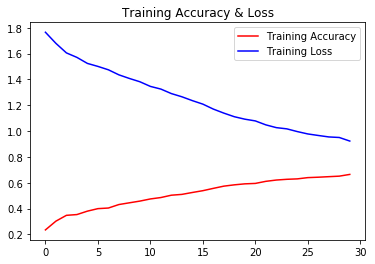

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.title("Training Accuracy & Loss")
plt.plot(epochs,loss,'b',label='Training Loss')
plt.legend()

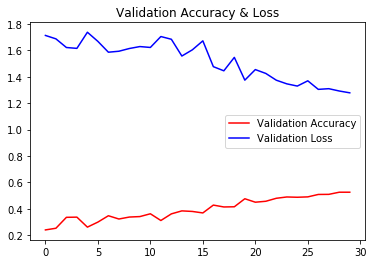

In [30]:
plt.clf()
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title("Validation Accuracy & Loss")
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.legend()

In [22]:
test_data_gen = ImageDataGenerator(rescale=1.0/255,data_format='channels_last')
test_set_generator = test_data_gen.flow_from_directory(test_data_set,target_size=(224,224),batch_size=32,class_mode='categorical',color_mode='rgb',shuffle=True)
first_model.evaluate_generator(test_set_generator,steps=2860//32,verbose=1)

Found 2860 images belonging to 6 classes.
89/89 [==============================] - 35s 390ms/step


[1.3223098596830047, 0.5379213483146067]

In [23]:
start = time.time()
history2 = first_model.fit_generator(train_set,steps_per_epoch=9918//16,epochs=30,validation_data=valid_set,validation_steps=1428//16,callbacks=[callback_ckpt])
print("time :", time.time() - start)
first_model.save("SqueezeNet_Transfer_Learning_2.h5")

Epoch 1/30
120/619 [====>.........................] - ETA: 2:53 - loss: 0.9337 - acc: 0.6599

C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


332/619 [===============>..............] - ETA: 1:41 - loss: 0.9179 - acc: 0.6657

C:\Users\Hou\AppData\Local\conda\conda\envs\Keras_TF\lib\site-packages\PIL\TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


619/619 [==============================] - 237s 384ms/step - loss: 0.9233 - acc: 0.6635 - val_loss: 1.2694 - val_acc: 0.5163
Epoch 2/30
619/619 [==============================] - 231s 373ms/step - loss: 0.8940 - acc: 0.6681 - val_loss: 1.2015 - val_acc: 0.5439
Epoch 3/30
619/619 [==============================] - 231s 373ms/step - loss: 0.8679 - acc: 0.6812 - val_loss: 1.2363 - val_acc: 0.5517
Epoch 4/30
619/619 [==============================] - 230s 372ms/step - loss: 0.8767 - acc: 0.6787 - val_loss: 1.1297 - val_acc: 0.5659
Epoch 5/30
619/619 [==============================] - 232s 375ms/step - loss: 0.8558 - acc: 0.6859 - val_loss: 1.1356 - val_acc: 0.5623
Epoch 6/30
619/619 [==============================] - 235s 379ms/step - loss: 0.8457 - acc: 0.6916 - val_loss: 1.1897 - val_acc: 0.5652
Epoch 7/30
619/619 [==============================] - 229s 369ms/step - loss: 0.8508 - acc: 0.6886 - val_loss: 1.1492 - val_acc: 0.5708
Epoch 8/30
619/619 [==============================] - 236s 

In [24]:
test_data_gen = ImageDataGenerator(rescale=1.0/255,data_format='channels_last')
test_set_generator = test_data_gen.flow_from_directory(test_data_set,target_size=(224,224),batch_size=32,class_mode='categorical',color_mode='rgb',shuffle=True)
first_model.evaluate_generator(test_set_generator,steps=2860//32,verbose=1)

Found 2860 images belonging to 6 classes.
89/89 [==============================] - 38s 422ms/step


[1.249154366134258, 0.5849719101123596]

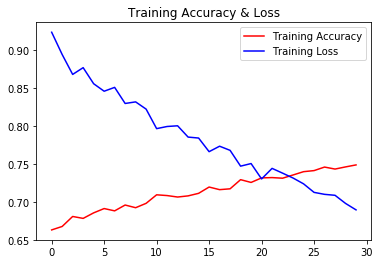

In [25]:
acc = history2.history['acc']
loss = history2.history['loss']
epochs = range(len(acc))
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.title("Training Accuracy & Loss")
plt.plot(epochs,loss,'b',label='Training Loss')
plt.legend()

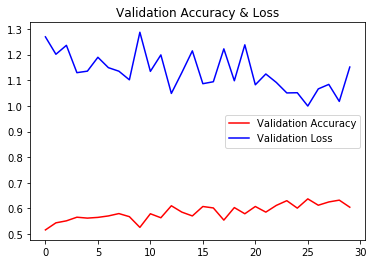

In [29]:
plt.clf()
val_acc = history2.history['val_acc']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title("Validation Accuracy & Loss")
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.legend()

In [28]:
start = time.time()
history3 = first_model.fit_generator(train_set,steps_per_epoch=15672//16,epochs=30,validation_data=valid_set,validation_steps=2254//16,callbacks=[callback_ckpt])
print("time :", time.time() - start)
first_model.save("SqueezeNet_Transfer_Learning_3.h5")

Epoch 1/30
979/979 [==============================] - 379s 387ms/step - loss: 0.6729 - acc: 0.7556 - val_loss: 1.0842 - val_acc: 0.6239
Epoch 2/30
979/979 [==============================] - 380s 388ms/step - loss: 0.6725 - acc: 0.7558 - val_loss: 1.0120 - val_acc: 0.6381
Epoch 3/30
979/979 [==============================] - 373s 381ms/step - loss: 0.6494 - acc: 0.7673 - val_loss: 1.0720 - val_acc: 0.6324
Epoch 4/30
979/979 [==============================] - 374s 382ms/step - loss: 0.6538 - acc: 0.7626 - val_loss: 1.2415 - val_acc: 0.5984
Epoch 5/30
 22/979 [..............................] - ETA: 3:21 - loss: 0.6028 - acc: 0.7756

KeyboardInterrupt: 

In [31]:
test_data_gen = ImageDataGenerator(rescale=1.0/255,data_format='channels_last')
test_set_generator = test_data_gen.flow_from_directory(test_data_set,target_size=(224,224),batch_size=32,class_mode='categorical',color_mode='rgb',shuffle=True)
first_model.evaluate_generator(test_set_generator,steps=2860//16,verbose=1)

Found 2860 images belonging to 6 classes.
178/178 [==============================] - 68s 383ms/step


[1.3359637537667917, 0.5856236786889392]

In [32]:
first_model.save("SqueezeNet_Transfer_Learning_3.h5")